## Simulación

In [18]:
import random
import numpy as np
import os
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from collections import defaultdict

In [19]:
random.seed(42)

class MatchSimulation:
    def __init__(self, home_players_dict, away_players_dict,home_team = 'Custom Home Team', away_team='Custom Away Team'):
        self.home_team = home_team
        self.away_team = away_team

        self.home_players = home_players_dict
        self.away_players = away_players_dict
        
        self.match_duration = random.randint(100, 120) 
        
        self.base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'  
        self.field = np.zeros((10, 10), dtype=int) 
        self.ball_position = [5, 5] 

        self.current_team = random.choice(['home', 'away']) 
        self.mins_played = 0 
        self.score = {'home': 0, 'away': 0}  

        self.interceptions = {'home': 0, 'away': 0}
        self.passes = {'home': 0, 'away': 0}
        self.shots = {'home': 0, 'away': 0}

        self.home_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10)),
            'goalkeeper_matrix': np.zeros((10,10))
            
        }
        self.away_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10)),
            'goalkeeper_matrix': np.zeros((10,10))  
        }

    def mirror_matrix(self, matrix):
        """Damos vuelta la matriz para que se enfrenten en el juego"""
        return np.fliplr(np.flipud(matrix))

    def normalize_matrix(self, matrix, match_duration):
        """como estan en pases/errores/out/shot etc x minuto las pasamos a probabilidades"""
        total_shots = matrix * match_duration
        total_events = np.sum(total_shots)
        probability_matrix = total_shots / total_events
        return probability_matrix

    def load_player_matrix(self, team_name, player_name, matrix_name):
        """Buscamos las matrices individuales (para armar al equipo)"""
        if matrix_name != 'pass_transition_matrix':
            
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.csv')
            matrix = np.loadtxt(matrix_path, delimiter=',')
        else:
            
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.npy')
            matrix = np.load(matrix_path)
        
        return matrix


    def aggregate_team_matrices(self, team):
        """Sumamos las matrices para el equipo especificado"""
        if team == 'home':
            for team_name, players in self.home_players.items():
                for player_name, _ in players:  
                    self.home_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.home_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.home_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.home_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.home_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.home_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.home_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix') 
                    self.home_team_matrixes['goalkeeper_matrix'] += self.load_player_matrix(team_name, player_name, 'goalkeeper_matrix') 

            # self.home_team_matrixes['pass_matrix'] = self.normalize_matrix(self.home_team_matrixes['pass_matrix'], self.match_duration) 
            # self.home_team_matrixes['shot_matrix'] = self.normalize_matrix(self.home_team_matrixes['shot_matrix'], self.match_duration) 
            # self.home_team_matrixes['defense_matrix'] = self.normalize_matrix(self.home_team_matrixes['defense_matrix'], self.match_duration) 
            # self.home_team_matrixes['goal_matrix'] = self.normalize_matrix(self.home_team_matrixes['goal_matrix'], self.match_duration) 
            # self.home_team_matrixes['error_matrix'] = self.normalize_matrix(self.home_team_matrixes['error_matrix'], self.match_duration) 
            # self.home_team_matrixes['out_matrix'] = self.normalize_matrix(self.home_team_matrixes['out_matrix'], self.match_duration) 
            self.home_team_matrixes['goalkeeper_matrix'] = self.mirror_matrix(self.home_team_matrixes['goalkeeper_matrix'])
           

        elif team == 'away':
            for team_name, players in self.away_players.items():
                for player_name, _ in players:  
                    self.away_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.away_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.away_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.away_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.away_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.away_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.away_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix')  
                    self.away_team_matrixes['goalkeeper_matrix'] += self.load_player_matrix(team_name, player_name, 'goalkeeper_matrix') 

            # self.away_team_matrixes['pass_matrix'] = self.mirror_matrix(self.normalize_matrix(self.away_team_matrixes['pass_matrix'], self.match_duration))
            # self.away_team_matrixes['shot_matrix'] = self.mirror_matrix(self.normalize_matrix(self.away_team_matrixes['shot_matrix'], self.match_duration))
            # self.away_team_matrixes['defense_matrix'] = self.mirror_matrix(self.normalize_matrix(self.away_team_matrixes['defense_matrix'], self.match_duration))
            # self.away_team_matrixes['goal_matrix'] = self.mirror_matrix(self.normalize_matrix(self.away_team_matrixes['goal_matrix'], self.match_duration))
            # self.away_team_matrixes['error_matrix'] = self.mirror_matrix(self.normalize_matrix(self.away_team_matrixes['error_matrix'], self.match_duration))
            # self.away_team_matrixes['out_matrix'] = self.mirror_matrix(self.normalize_matrix(self.away_team_matrixes['out_matrix'], self.match_duration))

            self.away_team_matrixes['pass_matrix'] = self.mirror_matrix(self.away_team_matrixes['pass_matrix'])
            self.away_team_matrixes['shot_matrix'] = self.mirror_matrix(self.away_team_matrixes['shot_matrix'])
            self.away_team_matrixes['defense_matrix'] = self.mirror_matrix(self.away_team_matrixes['defense_matrix'])
            self.away_team_matrixes['goal_matrix'] = self.mirror_matrix(self.away_team_matrixes['goal_matrix'])
            self.away_team_matrixes['error_matrix'] = self.mirror_matrix(self.away_team_matrixes['error_matrix'])
            self.away_team_matrixes['out_matrix'] = self.mirror_matrix(self.away_team_matrixes['out_matrix'])
           
        else:
            print(f'Error, {team} is not a valid team!')


    def get_team_data(self):
        """Cargar y preparar las matrices para los equipos"""
        self.aggregate_team_matrices('home')
        self.aggregate_team_matrices('away')

    
    def select_event(self, current_x, current_y):
        """Realizar un pase basado en la matriz de transiciones y seleccionar el evento con probabilidades acumuladas"""

        if self.current_team =='home':
            pass_probabilities = self.home_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)

            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size
            
            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.home_team_matrixes['pass_matrix'][next_position[0], next_position[1]] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.away_team_matrixes['defense_matrix'][next_position[0], next_position[1]]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.home_team_matrixes['error_matrix'][current_x, current_y]
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            shot_probability_ = self.home_team_matrixes['shot_matrix'][current_x, current_y]
            shot_probability = shot_probability_ if not np.isnan(shot_probability_) else 0
            # out_probability_ = self.home_team_matrixes['out_matrix'][current_x, current_y]
            # out_probability = out_probability_ if not np.isnan(out_probability_) else 0

            total_prob = pass_probability + defense_probability + error_probability + shot_probability 
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob 
                                # out_probability / total_prob
                                ]
            events = ['pass', 'interception', 'error', 'shot']

            selected_event = np.random.choice(events, p=normalized_probs)

        else:
            pass_probabilities = self.away_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)
            
            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size

            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.away_team_matrixes['pass_matrix'][next_position[0], next_position[1]] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.home_team_matrixes['defense_matrix'][next_position[0], next_position[1]]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.away_team_matrixes['error_matrix'][current_x, current_y]
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            shot_probability_ = self.away_team_matrixes['shot_matrix'][current_x, current_y]
            shot_probability = shot_probability_ if not np.isnan(shot_probability_) else 0
            # out_probability_ = self.away_team_matrixes['out_matrix'][current_x, current_y]
            # out_probability = out_probability_ if not np.isnan(out_probability_) else 0

            total_prob = pass_probability + defense_probability + error_probability + shot_probability 
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob
                                # out_probability / total_prob
            ]
        

            events = ['pass', 'interception', 'error', 'shot']
            selected_event = np.random.choice(events, p=normalized_probs)



        return selected_event, next_position,self.current_team

    def change_possession(self):
        self.current_team = 'home' if self.current_team == 'away' else 'away'

    def restart_from_middle(self):
        self.ball_position =[5,5]

    def step(self):
        events_per_minute = random.randint(8,12)
        for _ in range(events_per_minute):
            current_position = tuple(self.ball_position)
            current_x, current_y = current_position
            current_event, next_position, team = self.select_event(current_x, current_y)

            if current_event == 'pass':
                self.passes[team] += 1
                self.ball_position = next_position

            elif current_event == 'error':
                self.ball_position = current_position
                self.change_possession()

            elif current_event == 'interception':
                self.ball_position = current_position
                if team == 'home':
                    self.interceptions['away'] += 1
                else:
                    self.interceptions['home'] += 1
                self.change_possession()

            elif current_event == 'shot':
                goal_scored = self.shoot_ball(current_x, current_y)
                self.shots[team] += 1
                if goal_scored:
                    self.score[team] += 1
                    self.change_possession()
                    self.restart_from_middle()

            elif current_event == 'out':
                self.change_possession()
                self.restart_from_sideline(current_position)

        # print(f"[Minuto {self.mins_played}] {team} en {self.ball_position} realiza un {current_event}.")
        self.mins_played += 1


    def restart_from_sideline(self, out_position):
        """Reinicia el juego desde el lado de la cancha más cercano"""
        x, y = out_position
        if x <= 4: 
            new_x = 0
        else:  
            new_x = 9
        if y <= 4:  
            new_y = 0
        else:  
            new_y = 9
        self.ball_position = [new_x, new_y]


    def shoot_ball(self, current_x, current_y):
        """Evaluar el resultado de un tiro considerando gol, defensa y error, con un enfoque más conservador"""
        if self.current_team == 'home':
            if current_y < 5:
                return False
            goal_probability = self.home_team_matrixes['goal_matrix'][current_x, current_y]
            goal_added_probability = self.away_team_matrixes['error_matrix'][current_x,current_y]
           
            shot_probability = self.home_team_matrixes['shot_matrix'][current_x, current_y]
            shot_added_probability = self.away_team_matrixes['defense_matrix'][current_x, current_y]
          
            goalkeeper = self.away_team_matrixes['goalkeeper_matrix'][current_x,current_y]
            # goal_prob = max(0, (goal_probability + goal_added_probability) * (1 - min(1, goalkeeper)))
            # failed_shot_prob = max(0, (shot_probability + shot_added_probability) * goalkeeper)

            if goalkeeper != 0:
                goal_prob = (goal_probability + goal_added_probability) * (1 -  goalkeeper)
                failed_shot_prob = (shot_probability + shot_added_probability) * goalkeeper
            else:
                goal_prob = (goal_probability + goal_added_probability)
                failed_shot_prob = (shot_probability + shot_added_probability) 

            # print(f'Team Home - goal prob = {goal_prob}, shot_prob = {failed_shot_prob}')

            total_prob = goal_prob + failed_shot_prob
            normalized_probs = [failed_shot_prob / total_prob, goal_prob / total_prob]

            events = ['failed shot', 'goal']
            selected_event = np.random.choice(events, p=normalized_probs)
            
            if selected_event == 'goal':
                return True
            else:
                return False
         
        if self.current_team == 'away':
            if current_y > 5:
                return False
            goal_probability = self.away_team_matrixes['goal_matrix'][current_x, current_y]
            goal_added_probability = self.home_team_matrixes['error_matrix'][current_x,current_y]

            shot_probability = self.away_team_matrixes['shot_matrix'][current_x, current_y]
            shot_added_probability = self.home_team_matrixes['defense_matrix'][current_x, current_y]

            goalkeeper = self.home_team_matrixes['goalkeeper_matrix'][current_x,current_y]

            # goal_prob = max(0, (goal_probability + goal_added_probability) * (1 - min(1, goalkeeper)))
            # failed_shot_prob = max(0, (shot_probability + shot_added_probability) * goalkeeper)

            if goalkeeper != 0:
                goal_prob = (goal_probability + goal_added_probability) * (1 -  goalkeeper)
                failed_shot_prob = (shot_probability + shot_added_probability) * goalkeeper
            else:
                goal_prob = (goal_probability + goal_added_probability)
                failed_shot_prob = (shot_probability + shot_added_probability) 

            # print(f'Team Away - goal prob = {goal_prob}, shot_prob = {failed_shot_prob}')
            total_prob = goal_prob + failed_shot_prob
            normalized_probs = [failed_shot_prob / total_prob, goal_prob / total_prob]
        

            events = ['failed shot', 'goal']
            selected_event = np.random.choice(events, p=normalized_probs)

            if selected_event == 'goal':
                return True
            else:
                return False
        

    def play_match(self):
        self.get_team_data()
        while self.mins_played < self.match_duration:
            self.step()
        
        return {
            'home': self.home_team,
            'away': self.away_team,
            'goles_local': self.score['home'],
            'goles_visitante': self.score['away'],
            'tiros_local': self.shots['home'],
            'tiros_visitante': self.shots['away'],
            'pases_local': self.passes['home'],
            'pases_visitante': self.passes['away'],
            'quites_local': self.interceptions['home'],
            'quites_visitante': self.interceptions['away']
        }

## Manchester United vs Chelsea

Seteamos los equipos y sus planteles (los sacamos en base al 11 titular mas elegido en la temporada)

In [20]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [21]:
def get_team_players(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [22]:
def choose_teams(teams_list, players_data):
    """
    Permite al usuario elegir un equipo completo o un equipo personalizado.
    Devuelve un diccionario en el formato: {'TeamName': [(player1, periods), (player2, periods), ...]}
    """
    print("¿Cómo deseas elegir tu equipo?")
    print("1. Elegir un equipo completo")
    print("2. Seleccionar jugadores individuales de diferentes equipos")

    choice = input("Ingresa el número de tu elección (1 o 2): ")

    players_dict = defaultdict(list)  # Creamos el diccionario para almacenar la selección de jugadores

    if choice == '1':
        # Elegir un equipo completo
        print("Equipos disponibles:")
        for idx, team in enumerate(teams_list, start=1):
            print(f"{idx}. {team}")

        team_index = int(input("Selecciona el número del equipo que deseas elegir: ")) - 1

        if 0 <= team_index < len(teams_list):
            team_name = teams_list[team_index]
            selected_players = get_initial_11(team_name)  # Llama a la función que devuelve el equipo titular
            players_dict[team_name] = [(player, 'full_period') for player in selected_players]
            print(f"\nEquipo titular seleccionado para {team_name}: {selected_players}")
        else:
            print("Selección de equipo inválida.")

    elif choice == '2':
        # Selección de jugadores personalizados de diferentes equipos
        while sum(len(players) for players in players_dict.values()) < 11:
            print("Equipos disponibles:")
            for idx, team in enumerate(teams_list, start=1):
                print(f"{idx}. {team}")

            team_index = int(input("Selecciona el número del equipo para elegir jugadores: ")) - 1
    

            if 0 <= team_index < len(teams_list):
                team_name = teams_list[team_index]
                available_players = [player for player in players_data[team_name] 
                                     if player not in [p[0] for players in players_dict.values() for p in players]]

                while True:
                    print(f"Jugadores disponibles en {team_name}:")
                    for idx, player in enumerate(available_players, start=1):
                        print(f"{idx}. {player}")

                    player_index = int(input("Selecciona el número del jugador que deseas agregar (o 0 para cambiar de equipo): ")) - 1

                    if player_index == -1:
                        # Cambiar de equipo
                        break
                    elif 0 <= player_index < len(available_players):
                        players_dict[team_name].append((available_players[player_index], 'custom_period'))
                        print(f"Jugador {available_players[player_index]} agregado a tu equipo.")
                        print(f"Jugadores seleccionados: {sum(len(players) for players in players_dict.values())} / 11\n")

                        # Actualizar la lista de jugadores disponibles
                        available_players.pop(player_index)

                        # Si se alcanzan los 11 jugadores, salir del bucle
                        if sum(len(players) for players in players_dict.values()) == 11:
                            break
                    else:
                        print("Selección de jugador no válida.")
            else:
                print("Selección de equipo no válida.")

        if sum(len(players) for players in players_dict.values()) == 11:
            print("\nHas completado tu equipo:")
        else:
            print("\nNo has completado los 11 jugadores, pero esta es tu selección final:")
        print(players_dict)

    else:
        print("Opción inválida. Por favor, elige 1 o 2.")

    return players_dict

In [23]:
df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter = ';')

In [24]:
teams_list = df['home_team_name'].unique()

In [25]:
players_dict = defaultdict(list)

for team in teams_list:
    players = get_team_players(team)
    if players:  
        players_dict[team] = players

## Simulamos el partido

Simulamos partidos entre manchester united y chelsea, guardamos resultados y analizamos

In [26]:
random.seed(42)
def simulate_matches(num_matches, home_players, away_players):
    results = []
    for _ in tqdm(range(num_matches), desc="Simulando partidos", unit="partido"):
        home_team_name = list(home_players.keys())[0] if len(home_players) == 1 else None
        away_team_name = list(away_players.keys())[0] if len(away_players) == 1 else None
        if home_team_name == None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players)
        elif home_team_name != None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players, home_team=home_team_name)
        elif home_team_name == None and away_team_name != None:
            simulation = MatchSimulation(home_players, away_players, away_team=away_team_name)
        else:
            simulation = MatchSimulation(home_players, away_players, home_team= home_team_name, away_team= away_team_name)
        result = simulation.play_match()
        results.append(result)
    return pd.DataFrame(results)

In [69]:
home_players = choose_teams(teams_list, players_dict)
away_players = choose_teams(teams_list, players_dict)

df_results = simulate_matches(1000, home_players, away_players)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West Ham United
10. Wigan Athletic
11. Aston Villa
12. Chelsea
13. Liverpool
14. Manchester United
15. Norwich City
16. Southampton
17. Stoke City
18. Sunderland
19. Swansea City
20. Tottenham Hotspur

Equipo titular seleccionado para Queens Park Rangers: ['Hill, Clint', 'Mbia, Stephane', 'Taarabt, Adel', 'Cesar, Julio', 'Traore, Armand', 'Nelsen, Ryan', 'Bosingwa, Jose', 'Mackie, Jamie', 'Granero, Esteban', 'Onuoha, Nedum', 'Hoilett, Junior']
¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West H

Simulando partidos: 100%|██████████| 1000/1000 [02:23<00:00,  6.98partido/s]


In [70]:
df_results['winner'] = df_results.apply(
    lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                 row['away'] if row['goles_local'] < row['goles_visitante'] else
                 'tie', axis=1
)

In [71]:
df_results

,home,away,goles_local,goles_visitante,tiros_local,tiros_visitante,pases_local,pases_visitante,quites_local,quites_visitante,winner
0,Queens Park Rangers,Manchester United,0,0,5,2,320,466,128,115,tie
1,Queens Park Rangers,Manchester United,0,1,4,2,300,418,123,121,Manchester United
2,Queens Park Rangers,Manchester United,0,1,3,8,261,419,115,94,Manchester United
3,Queens Park Rangers,Manchester United,0,0,3,3,257,411,109,100,tie
4,Queens Park Rangers,Manchester United,1,2,2,3,328,420,123,106,Manchester United
...,...,...,...,...,...,...,...,...,...,...,...
995,Queens Park Rangers,Manchester United,0,0,5,6,242,455,121,118,tie
996,Queens Park Rangers,Manchester United,0,0,6,10,282,433,109,99,tie
997,Queens Park Rangers,Manchester United,0,1,7,6,323,427,127,112,Manchester United
998,Queens Park Rangers,Manchester United,0,1,9,9,342,455,124,109,Manchester United


In [72]:
df_results['winner'].value_counts()

winner
tie                    439
Manchester United      435
Queens Park Rangers    126
Name: count, dtype: int64

In [73]:
home_players = choose_teams(teams_list, players_dict)
away_players = choose_teams(teams_list, players_dict)

df_results_change = simulate_matches(1000, home_players, away_players)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West Ham United
10. Wigan Athletic
11. Aston Villa
12. Chelsea
13. Liverpool
14. Manchester United
15. Norwich City
16. Southampton
17. Stoke City
18. Sunderland
19. Swansea City
20. Tottenham Hotspur

Equipo titular seleccionado para Queens Park Rangers: ['Hill, Clint', 'Mbia, Stephane', 'Taarabt, Adel', 'Cesar, Julio', 'Traore, Armand', 'Nelsen, Ryan', 'Bosingwa, Jose', 'Mackie, Jamie', 'Granero, Esteban', 'Onuoha, Nedum', 'Hoilett, Junior']
¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West H

Simulando partidos: 100%|██████████| 1000/1000 [02:24<00:00,  6.91partido/s]


In [74]:
df_results_change['winner'] = df_results_change.apply(
    lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                 row['away'] if row['goles_local'] < row['goles_visitante'] else
                 'tie', axis=1
)

In [75]:
df_results_change['winner'].value_counts()

winner
Manchester United      484
tie                    402
Queens Park Rangers    114
Name: count, dtype: int64

In [76]:
counts_results = df_results['winner'].value_counts()
counts_change = df_results_change['winner'].value_counts()

In [77]:
counts_results

winner
tie                    439
Manchester United      435
Queens Park Rangers    126
Name: count, dtype: int64

In [78]:
counts_change

winner
Manchester United      484
tie                    402
Queens Park Rangers    114
Name: count, dtype: int64

In [79]:
df_counts_results = counts_results.reset_index()
df_counts_results.columns = ['Result', 'Count']  

In [80]:
df_counts_results_change = counts_change.reset_index()
df_counts_results_change.columns = ['Result', 'Count']  

In [81]:
df_combined = pd.merge(df_counts_results, df_counts_results_change, on='Result', how='outer')

In [82]:
df_combined.columns = ['Winner','Amount' ,'Amount w/o Van Persie']  

In [83]:
df_combined

,Winner,Amount,Amount w/o Van Persie
0,Manchester United,435,484
1,Queens Park Rangers,126,114
2,tie,439,402


In [84]:
new_index = ['win%', 'loss%', 'tie%', 'new win%', 'new loss%', 'new tie%']
teams = ['Manchester United', 'Queens Park Rangers']
df_transposed = pd.DataFrame(index=new_index, columns=teams)
# Calcular el total de juegos
total_games = df_combined['Amount'].sum()

# Asignar porcentajes de victorias
df_transposed.loc['win%', 'Manchester United'] = (df_combined.loc[0, 'Amount'] / total_games) * 100
df_transposed.loc['win%', 'Queens Park Rangers'] = (df_combined.loc[1, 'Amount'] / total_games) * 100

# Asignar porcentajes de empates
df_transposed.loc['tie%', 'Manchester United'] = (df_combined.loc[2, 'Amount'] / total_games) * 100
df_transposed.loc['tie%', 'Queens Park Rangers'] = (df_combined.loc[2, 'Amount'] / total_games) * 100

# Asignar porcentajes de pérdidas
df_transposed.loc['loss%', 'Manchester United'] = df_transposed.loc['win%', 'Queens Park Rangers']
df_transposed.loc['loss%', 'Queens Park Rangers'] = df_transposed.loc['win%', 'Manchester United']

# Calcular porcentajes de nuevas victorias
df_transposed.loc['new win%', 'Manchester United'] = (df_combined.loc[0, 'Amount w/o Van Persie'] / total_games) * 100
df_transposed.loc['new win%', 'Queens Park Rangers'] = (df_combined.loc[1, 'Amount w/o Van Persie'] / total_games) * 100

# Calcular porcentajes de nuevos empates
df_transposed.loc['new tie%', 'Manchester United'] = (df_combined.loc[2, 'Amount w/o Van Persie'] / total_games) * 100
df_transposed.loc['new tie%', 'Queens Park Rangers'] = (df_combined.loc[2, 'Amount w/o Van Persie'] / total_games) * 100

# Asignar nuevos porcentajes de pérdidas
df_transposed.loc['new loss%', 'Manchester United'] = df_transposed.loc['new win%', 'Queens Park Rangers']
df_transposed.loc['new loss%', 'Queens Park Rangers'] = df_transposed.loc['new win%', 'Manchester United']


In [85]:
df_transposed

,Manchester United,Queens Park Rangers
win%,43.5,12.6
loss%,12.6,43.5
tie%,43.9,43.9
new win%,48.4,11.4
new loss%,11.4,48.4
new tie%,40.2,40.2


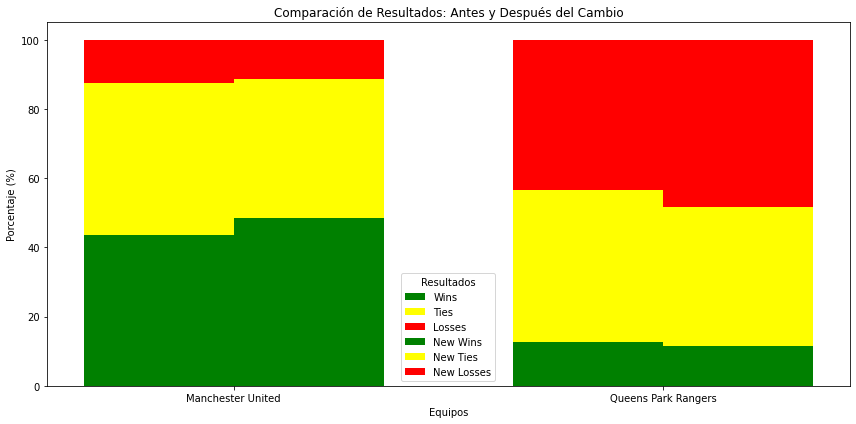

In [87]:
df_plot = df_transposed.transpose()
df_plot.columns = ['Wins', 'Losses', 'Ties', 'New Wins', 'New Losses', 'New Ties']

bar_width = 0.35  # Ancho de las barras
x = np.arange(len(df_plot))  # Posiciones en el eje x

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - bar_width / 2, df_plot['Wins'], width=bar_width, label='Wins', color='green')
ax.bar(x - bar_width / 2, df_plot['Ties'], width=bar_width, label='Ties', color='yellow', bottom=df_plot['Wins'])
ax.bar(x - bar_width / 2, df_plot['Losses'], width=bar_width, label='Losses', color='red', bottom=df_plot['Wins'] + df_plot['Ties'])

ax.bar(x + bar_width / 2, df_plot['New Wins'], width=bar_width, label='New Wins', color='green')
ax.bar(x + bar_width / 2, df_plot['New Ties'], width=bar_width, label='New Ties', color='yellow', bottom=df_plot['New Wins'])
ax.bar(x + bar_width / 2, df_plot['New Losses'], width=bar_width, label='New Losses', color='red', bottom=df_plot['New Wins'] + df_plot['New Ties'])

ax.set_title('Comparación de Resultados: Antes y Después del Cambio')
ax.set_ylabel('Porcentaje (%)')
ax.set_xlabel('Equipos')
ax.set_xticks(x)
ax.set_xticklabels(['Manchester United', 'Queens Park Rangers'])
ax.legend(title='Resultados')

plt.tight_layout()
plt.show()

## Graficos

In [52]:
def simulate_and_compare(teams_list, players_dict, num_matches=100):
    home_players = choose_teams(teams_list, players_dict)
    away_players = choose_teams(teams_list, players_dict)
    
    df_results = simulate_matches(num_matches, home_players, away_players)

    home_players_change = choose_teams(teams_list, players_dict)
    away_players_change = choose_teams(teams_list, players_dict)
    
    df_results_change = simulate_matches(num_matches, home_players_change, away_players_change)

    home_players_names = [player[0] for team, players in home_players.items() for player in players]
    away_players_names = [player[0] for team, players in away_players.items() for player in players]
    home_players_change_names = [player[0] for team, players in home_players_change.items() for player in players]
    away_players_change_names = [player[0] for team, players in away_players_change.items() for player in players]

    summary_data = {
        'home_players': home_players_names,
        'away_players': away_players_names,
        'home_players_change': home_players_change_names,
        'away_players_change': away_players_change_names,
    }
    
    summary_data['home_player_diff'] = list(set(home_players_names) - set(home_players_change_names))
    summary_data['away_player_diff'] = list(set(away_players_names) - set(away_players_change_names))

    home_goals = df_results['goles_local'].mean()
    away_goals = df_results['goles_visitante'].mean()
    
    home_goals_change = df_results_change['goles_local'].mean()
    away_goals_change = df_results_change['goles_visitante'].mean()

    summary_data.update({
        'home_goals': home_goals,
        'away_goals': away_goals,
        'home_goals_change': home_goals_change,
        'away_goals_change': away_goals_change,
        'home_goals_%_change': ((home_goals_change - home_goals) / home_goals) * 100 if home_goals != 0 else None,
        'away_goals_%_change': ((away_goals_change - away_goals) / away_goals) * 100 if away_goals != 0 else None,
    })

    home_shots = df_results['tiros_local'].mean()
    away_shots = df_results['tiros_visitante'].mean()
    
    home_shots_change = df_results_change['tiros_local'].mean()
    away_shots_change = df_results_change['tiros_visitante'].mean()

    summary_data.update({
        'home_shots': home_shots,
        'away_shots': away_shots,
        'home_shots_change': home_shots_change,
        'away_shots_change': away_shots_change,
        'home_shots_%_change': ((home_shots_change - home_shots) / home_shots) * 100 if home_shots != 0 else None,
        'away_shots_%_change': ((away_shots_change - away_shots) / away_shots) * 100 if away_shots != 0 else None,
    })

    home_interceptions = df_results['quites_local'].mean()
    away_interceptions = df_results['quites_visitante'].mean()
    
    home_interceptions_change = df_results_change['quites_local'].mean()
    away_interceptions_change = df_results_change['quites_visitante'].mean()

    summary_data.update({
        'home_interceptions': home_interceptions,
        'away_interceptions': away_interceptions,
        'home_interceptions_change': home_interceptions_change,
        'away_interceptions_change': away_interceptions_change,
        'home_interceptions_%_change': ((home_interceptions_change - home_interceptions) / home_interceptions) * 100 if home_interceptions != 0 else None,
        'away_interceptions_%_change': ((away_interceptions_change - away_interceptions) / away_interceptions) * 100 if away_interceptions != 0 else None,
    })

    # Calculate rival passes
    home_passes = df_results['pases_visitante'].mean()
    away_passes = df_results['pases_local'].mean()
    
    home_passes_change = df_results_change['pases_visitante'].mean()
    away_passes_change = df_results_change['pases_local'].mean()

    summary_data.update({
        'home_passes': home_passes,
        'away_passes': away_passes,
        'home_passes_%_change': ((home_passes_change - home_passes) / home_passes) * 100 if home_passes != 0 else None,
        'away_passes_%_change': ((away_passes_change - away_passes) / away_passes) * 100 if away_passes != 0 else None,
    })

    home_goals_per_shot = df_results['goles_local'].sum() / df_results['tiros_local'].sum() if home_shots > 0 else None
    away_goals_per_shot = df_results['goles_visitante'].sum() / df_results['tiros_visitante'].sum() if home_shots > 0 else None
    
    home_goals_per_shot_change = home_goals_change / home_shots_change if home_shots_change > 0 else None
    away_goals_per_shot_change = away_goals_change / away_shots_change if away_shots_change > 0 else None

    summary_data.update({
        'home_goals_per_shot': home_goals_per_shot,
        'away_goals_per_shot': away_goals_per_shot,
        'home_goals_per_shot_change': home_goals_per_shot_change,
        'away_goals_per_shot_change': away_goals_per_shot_change,
    })

    summary_df = pd.DataFrame([summary_data])
    return summary_df, df_results, df_results_change


summary_results_df = simulate_and_compare(teams_list, players_dict)


¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West Ham United
10. Wigan Athletic
11. Aston Villa
12. Chelsea
13. Liverpool
14. Manchester United
15. Norwich City
16. Southampton
17. Stoke City
18. Sunderland
19. Swansea City
20. Tottenham Hotspur

Equipo titular seleccionado para Queens Park Rangers: ['Hill, Clint', 'Mbia, Stephane', 'Taarabt, Adel', 'Cesar, Julio', 'Traore, Armand', 'Nelsen, Ryan', 'Bosingwa, Jose', 'Mackie, Jamie', 'Granero, Esteban', 'Onuoha, Nedum', 'Hoilett, Junior']
¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West H

Simulando partidos: 100%|██████████| 100/100 [00:10<00:00,  9.96partido/s]


¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West Ham United
10. Wigan Athletic
11. Aston Villa
12. Chelsea
13. Liverpool
14. Manchester United
15. Norwich City
16. Southampton
17. Stoke City
18. Sunderland
19. Swansea City
20. Tottenham Hotspur

Equipo titular seleccionado para Queens Park Rangers: ['Hill, Clint', 'Mbia, Stephane', 'Taarabt, Adel', 'Cesar, Julio', 'Traore, Armand', 'Nelsen, Ryan', 'Bosingwa, Jose', 'Mackie, Jamie', 'Granero, Esteban', 'Onuoha, Nedum', 'Hoilett, Junior']
¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Arsenal
2. Everton
3. Fulham
4. Manchester City
5. Newcastle United
6. Queens Park Rangers
7. Reading
8. West Bromwich Albion
9. West H

Simulando partidos: 100%|██████████| 100/100 [00:12<00:00,  8.15partido/s]


In [54]:
summary_results_df[0].columns

Index(['home_players', 'away_players', 'home_players_change',
       'away_players_change', 'home_player_diff', 'away_player_diff',
       'home_goals', 'away_goals', 'home_goals_change', 'away_goals_change',
       'home_goals_%_change', 'away_goals_%_change', 'home_shots',
       'away_shots', 'home_shots_change', 'away_shots_change',
       'home_shots_%_change', 'away_shots_%_change', 'home_interceptions',
       'away_interceptions', 'home_interceptions_change',
       'away_interceptions_change', 'home_interceptions_%_change',
       'away_interceptions_%_change', 'home_passes', 'away_passes',
       'home_passes_%_change', 'away_passes_%_change', 'home_goals_per_shot',
       'away_goals_per_shot', 'home_goals_per_shot_change',
       'away_goals_per_shot_change'],
      dtype='object')

In [55]:
path = '/Users/luisalawson/Downloads/summary_results_df.xlsx'

In [56]:
summary_results_df[0].to_excel(path, index = False)

In [38]:
player_change = (summary_results_df[0]['away_player_diff'])[0]

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_2172/1765886263.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)


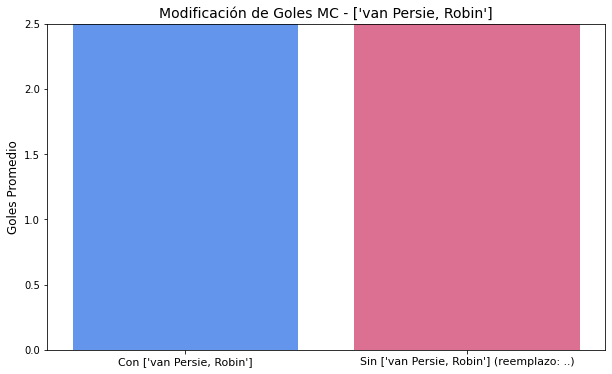

In [39]:
columnas = ['away_goals', 'away_goals_change']
porcentaje_cambio = 'away_goals_%_change'

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(columnas, summary_results_df[columnas].iloc[0], color=['cornflowerblue', 'palevioletred'])

center_position = (bars[0].get_x() + bars[1].get_x() + bars[1].get_width()) / 2

ax.annotate(f'{summary_results_df[porcentaje_cambio].iloc[0]:.2f}%',
            xy=(center_position, max([bar.get_height() for bar in bars])),
            xytext=(0, 5),  
            textcoords='offset points',
            ha='center', va='bottom', color='red')

ax.set_ylabel('Goles Promedio', fontsize=12)
ax.set_ylim(0.0,2.5) #esto it cambiandolo para que se lea bien el numero con los limites del grafico

nuevas_etiquetas = [f'Con {player_change}', f'Sin {player_change} (reemplazo: ..)']
ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)

ax.set_title(f'Modificación de Goles MC - {player_change}', fontsize=14)
plt.show()

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_2172/787721576.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)


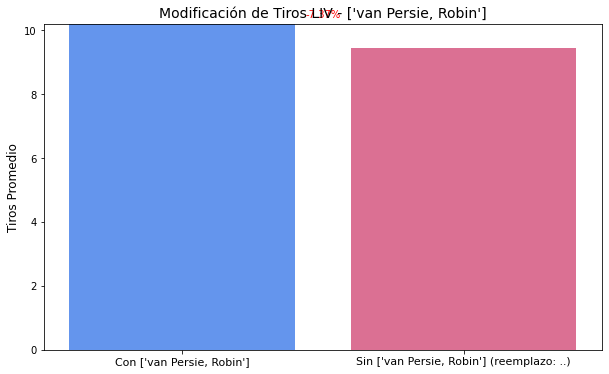

In [40]:
columnas = ['away_shots', 'away_shots_change'] #cambiar segun analisis
porcentaje_cambio = 'away_shots_%_change' #cambiar segun analisis

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(columnas, summary_results_df[columnas].iloc[0], color=['cornflowerblue', 'palevioletred'])

center_position = (bars[0].get_x() + bars[1].get_x() + bars[1].get_width()) / 2

ax.annotate(f'{summary_results_df[porcentaje_cambio].iloc[0]:.2f}%',
            xy=(center_position, max([bar.get_height() for bar in bars])),
            xytext=(0, 5),  
            textcoords='offset points',
            ha='center', va='bottom', color='red')

ax.set_ylabel('Tiros Promedio', fontsize=12) #cambiar segun analisis
ax.set_ylim(0,10.2) #esto it cambiandolo para que se lea bien el numero con los limites del grafico

nuevas_etiquetas = [f'Con {player_change}', f'Sin {player_change} (reemplazo: ..)']
ax.set_xticklabels(nuevas_etiquetas, rotation=0, fontsize=11)

ax.set_title(f'Modificación de Tiros LIV - {player_change}', fontsize=14)  #cambiar segun analisis
plt.show()